In [1]:
import tensorflow as tf 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

import tensorflow_datasets as tfds

In [2]:
np.random.seed(0)

In [3]:
dataset, info = tfds.load('glue/sst2', with_info=True)

In [4]:
info.dataset_size

0

In [5]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})

In [6]:
##get the train and validation dataset

train_ds , test_ds = dataset['train'], dataset['validation']
train_ds

<PrefetchDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [7]:
for example in train_ds.take(2):
    review, label = example['sentence'], example['label']
    print("Review: ", review)
    print("Label: ", label.numpy())

Review:  tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label:  0
Review:  tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label:  0


In [8]:
## take a subset of train data because there are 67K records 
train_reviews = []
train_labels = []

for review in train_ds.take(5000):
    sentence, label = review['sentence'], review['label']
    train_reviews.append(str(sentence.numpy()))
    train_labels.append(label.numpy())
    
print(train_reviews[0], ' ==> ', train_labels[0])    

b'for the uninitiated plays better on video with the sound '  ==>  0


In [9]:
# take all test data as there are only 872 records

len(test_ds)

872

In [10]:
test_reviews = []
test_labels = []

for review in test_ds.take(-1):
    sentence, label = review['sentence'], review['label']
    test_reviews.append(str(sentence.numpy()))
    test_labels.append(label.numpy())
    
print(test_reviews[0], ' ==> ', test_labels[0])    
    

b'a valueless kiddie paean to pro basketball underwritten by the nba . '  ==>  0


## Test Preprocessing 

In [11]:
vocab_size = 2000
embedding_dim = 16
max_length = 50


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

In [14]:
tokenizer.fit_on_texts(train_reviews)

In [15]:
word_idx = tokenizer.word_index
len(word_idx)

8717

In [16]:
## pad sequences
train_seq = tokenizer.texts_to_sequences(train_reviews)
train_padded_seq = pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')

test_seq = tokenizer.texts_to_sequences(test_reviews)
test_padded_seq = pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')

train_label = np.array(train_labels)
test_labels = np.array(test_labels)


### Generic Method

In [17]:
EPOCHS = 30
    
def fit_model_show_results(model):
    history = fit_model(model)
    
    plot_results(history, 'loss')
    plot_results(history, 'accuracy')
    

def plot_results(history, metric):
    
    train = history.history[metric]
    val = history.history['val_' + metric]

    x_rng = range(0, EPOCHS)
    
    plt.plot(x_rng, train, label ='Training ' + metric)
    plt.plot(x_rng, val, label ='Validation '+ metric)

    plt.legend()
    plt.show()
    
    
def fit_model(model):
    
    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
             metrics=['accuracy'], 
             optimizer='adam')
    

    history = model.fit(train_padded_seq, 
         train_label, 
         epochs=EPOCHS, 
         validation_data=(test_padded_seq, test_labels)           
         )
    
    return history
  
def predict_reviews(model, fake_reviews):
    
    seq = tokenizer.texts_to_sequences(fake_reviews)

    fake_pd_seq = pad_sequences(seq, maxlen = max_length, padding='post', truncating='post')
    
    classes = model.predict(fake_pd_seq)

    for c in np.arange(0, len(fake_pd_seq)):
        cl = ('-ve' if np.argmax(classes[c]) == 0 else '+ve')

        print(fake_reviews[c] , ' ==> ', cl , ' ==> ', classes[c])    

## Embeddings  Model

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=6, activation='relu'), 
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            32000     
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 4806      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
Total params: 36,820
Trainable params: 36,820
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
157/157 [==============================] - 0s 1ms/step - loss: 0.6832 - accuracy: 0.5608 - val_loss: 0.6885 - val_accuracy: 0.5092
Epoch 2/30
157/157 [==============================] - 0s 716us/step - loss: 0.6461 - accuracy: 0.6066 - val_loss: 0.6436 - val_accuracy: 0.6273
Epoch 3/30
157/157 [==============================] - 0s 721us/step - loss: 0.5371 - accuracy: 0.7534 - val_loss: 0.6038 - val_accuracy: 0.6720
Epoch 4/30
157/157 [==============================] - 0s 738us/step - loss: 0.4310 - accuracy: 0.8386 - val_loss: 0.5935 - val_accuracy: 0.7018
Epoch 5/30
157/157 [==============================] - 0s 737us/step - loss: 0.2930 - accuracy: 0.8792 - val_loss: 0.6293 - val_accuracy: 0.7064
Epoch 6/30
157/157 [==============================] - 0s 703us/step - loss: 0.2171 - accuracy: 0.9026 - val_loss: 0.6907 - val_accuracy: 0.6995
Epoch 7/30
157/157 [==============================] - 0s 697us/step - loss: 0.1824 - accuracy: 0.9146 - val_loss: 0.7726 - val_accuracy: 0

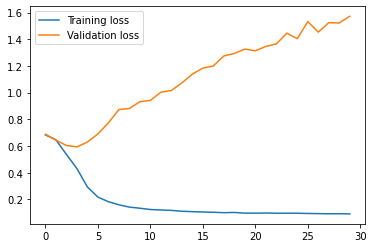

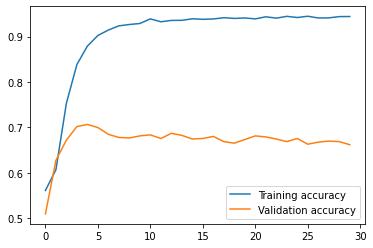

In [19]:
fit_model_show_results(model)

## CNN

In [20]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), 
    tf.keras.layers.Conv1D(16, 5, activation='relu'), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            32000     
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            1296      
_________________________________________________________________
flatten_1 (Flatten)          (None, 736)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1474      
Total params: 34,770
Trainable params: 34,770
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
157/157 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.5694 - val_loss: 0.6871 - val_accuracy: 0.5539
Epoch 2/30
157/157 [==============================] - 0s 1ms/step - loss: 0.5898 - accuracy: 0.6958 - val_loss: 0.5669 - val_accuracy: 0.7190
Epoch 3/30
157/157 [==============================] - 0s 1ms/step - loss: 0.4063 - accuracy: 0.8110 - val_loss: 0.6316 - val_accuracy: 0.6823
Epoch 4/30
157/157 [==============================] - 0s 1ms/step - loss: 0.3270 - accuracy: 0.8424 - val_loss: 0.6574 - val_accuracy: 0.6835
Epoch 5/30
157/157 [==============================] - 0s 1ms/step - loss: 0.2747 - accuracy: 0.8672 - val_loss: 0.6947 - val_accuracy: 0.7156
Epoch 6/30
157/157 [==============================] - 0s 1ms/step - loss: 0.2367 - accuracy: 0.8832 - val_loss: 0.7654 - val_accuracy: 0.6892
Epoch 7/30
157/157 [==============================] - 0s 1ms/step - loss: 0.2059 - accuracy: 0.9022 - val_loss: 0.8566 - val_accuracy: 0.7076
Epoch 

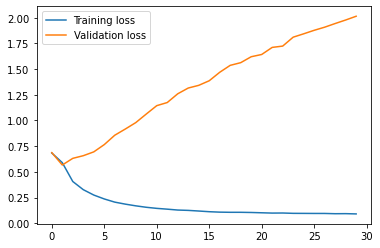

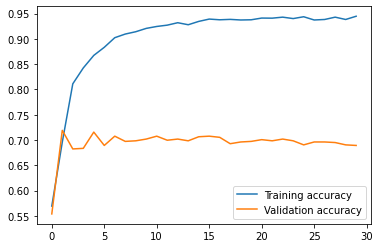

In [21]:
fit_model_show_results(model_cnn)

## GRU

In [22]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), 
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(units=2, activation='softmax')
    
])

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            32000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 41,730
Trainable params: 41,730
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
157/157 [==============================] - 3s 22ms/step - loss: 0.6645 - accuracy: 0.5886 - val_loss: 0.6062 - val_accuracy: 0.6846
Epoch 2/30
157/157 [==============================] - 3s 19ms/step - loss: 0.4794 - accuracy: 0.7622 - val_loss: 0.5843 - val_accuracy: 0.7317
Epoch 3/30
157/157 [==============================] - 3s 20ms/step - loss: 0.3802 - accuracy: 0.8190 - val_loss: 0.6127 - val_accuracy: 0.7053
Epoch 4/30
157/157 [==============================] - 3s 19ms/step - loss: 0.3316 - accuracy: 0.8418 - val_loss: 0.6911 - val_accuracy: 0.7385
Epoch 5/30
157/157 [==============================] - 3s 21ms/step - loss: 0.3042 - accuracy: 0.8560 - val_loss: 0.7093 - val_accuracy: 0.6950
Epoch 6/30
157/157 [==============================] - 3s 20ms/step - loss: 0.2857 - accuracy: 0.8580 - val_loss: 0.7336 - val_accuracy: 0.7305
Epoch 7/30
157/157 [==============================] - 3s 20ms/step - loss: 0.2694 - accuracy: 0.8704 - val_loss: 0.9758 - val_accuracy: 0.7030

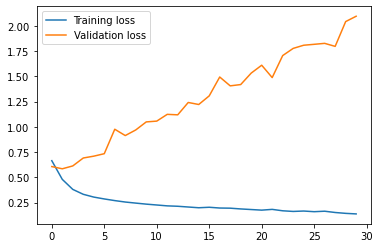

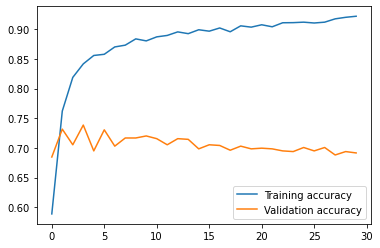

In [23]:
fit_model_show_results(model_gru)

## LSTM

In [24]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(units=2, activation='softmax')
    
])

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            32000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 36,290
Trainable params: 36,290
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
157/157 [==============================] - 3s 20ms/step - loss: 0.6773 - accuracy: 0.5730 - val_loss: 0.6634 - val_accuracy: 0.6021
Epoch 2/30
157/157 [==============================] - 2s 16ms/step - loss: 0.5518 - accuracy: 0.7278 - val_loss: 0.5690 - val_accuracy: 0.7144
Epoch 3/30
157/157 [==============================] - 2s 15ms/step - loss: 0.4077 - accuracy: 0.8082 - val_loss: 0.5988 - val_accuracy: 0.7259
Epoch 4/30
157/157 [==============================] - 3s 16ms/step - loss: 0.3430 - accuracy: 0.8408 - val_loss: 0.6258 - val_accuracy: 0.7190
Epoch 5/30
157/157 [==============================] - 3s 17ms/step - loss: 0.3081 - accuracy: 0.8558 - val_loss: 0.6837 - val_accuracy: 0.7317
Epoch 6/30
157/157 [==============================] - 3s 17ms/step - loss: 0.2870 - accuracy: 0.8658 - val_loss: 0.7305 - val_accuracy: 0.7305
Epoch 7/30
157/157 [==============================] - 3s 17ms/step - loss: 0.2667 - accuracy: 0.8736 - val_loss: 0.7899 - val_accuracy: 0.7271

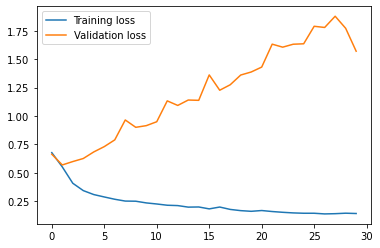

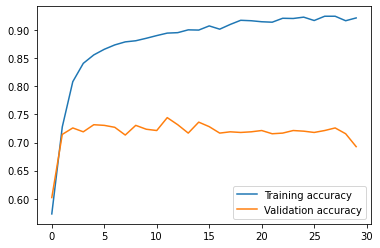

In [25]:
fit_model_show_results(model_lstm)

## Multiple LSTM

In [26]:
model_mlstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(units=2, activation='softmax')
    
])

model_mlstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 16)            32000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 42,562
Trainable params: 42,562
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
157/157 [==============================] - 6s 36ms/step - loss: 0.6697 - accuracy: 0.5800 - val_loss: 0.6212 - val_accuracy: 0.6411
Epoch 2/30
157/157 [==============================] - 5s 31ms/step - loss: 0.4849 - accuracy: 0.7578 - val_loss: 0.5570 - val_accuracy: 0.7213
Epoch 3/30
157/157 [==============================] - 5s 32ms/step - loss: 0.3705 - accuracy: 0.8244 - val_loss: 0.6561 - val_accuracy: 0.7305
Epoch 4/30
157/157 [==============================] - 5s 33ms/step - loss: 0.3302 - accuracy: 0.8422 - val_loss: 0.6312 - val_accuracy: 0.7328
Epoch 5/30
157/157 [==============================] - 6s 35ms/step - loss: 0.2945 - accuracy: 0.8624 - val_loss: 0.7619 - val_accuracy: 0.7179
Epoch 6/30
157/157 [==============================] - 5s 34ms/step - loss: 0.2753 - accuracy: 0.8692 - val_loss: 0.8275 - val_accuracy: 0.7144
Epoch 7/30
157/157 [==============================] - 5s 32ms/step - loss: 0.2613 - accuracy: 0.8770 - val_loss: 0.8148 - val_accuracy: 0.7213

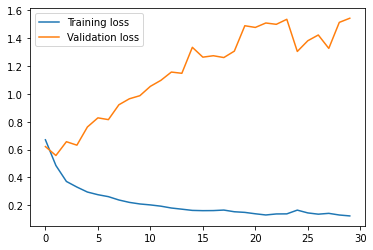

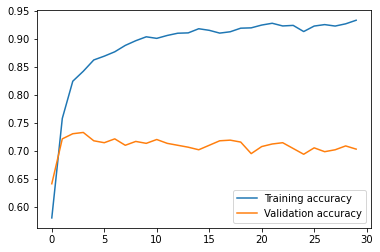

In [27]:
fit_model_show_results(model_mlstm)

## predict reviews

In [28]:
review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10]

In [29]:
print("===== Embeddings Model =====\n")

predict_reviews(model, more_reviews)

===== Embeddings Model =====

I loved this movie  ==>  +ve  ==>  [2.3672532e-04 9.9976331e-01]
that was the worst movie I've ever seen  ==>  -ve  ==>  [0.9230552  0.07694481]
too much violence even for a Bond film  ==>  -ve  ==>  [0.997413   0.00258701]
a captivating recounting of a cherished myth  ==>  +ve  ==>  [0.00489878 0.9951013 ]
I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.  ==>  -ve  ==>  [0.98402876 0.0159713 ]
I don't understand why it received an oscar recommendation
 for best movie, it was long and boring  ==>  +ve  ==>  [0.00881003 0.99118996]
the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!  ==>  +ve  ==>  [0.15259273 0.8474072 ]
The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it a

In [30]:
print("===== CNN Model =====\n")

predict_reviews(model_cnn, more_reviews)

===== CNN Model =====

I loved this movie  ==>  +ve  ==>  [0.00542446 0.9945755 ]
that was the worst movie I've ever seen  ==>  -ve  ==>  [0.99745744 0.00254263]
too much violence even for a Bond film  ==>  -ve  ==>  [9.9999452e-01 5.4375464e-06]
a captivating recounting of a cherished myth  ==>  +ve  ==>  [1.6981133e-04 9.9983013e-01]
I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.  ==>  +ve  ==>  [3.2162993e-06 9.9999678e-01]
I don't understand why it received an oscar recommendation
 for best movie, it was long and boring  ==>  +ve  ==>  [8.641289e-04 9.991359e-01]
the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!  ==>  -ve  ==>  [9.9999797e-01 2.0783486e-06]
The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an exc

In [31]:
print("===== GRU Model =====\n")

predict_reviews(model_gru, more_reviews)

===== GRU Model =====

I loved this movie  ==>  +ve  ==>  [4.0397324e-04 9.9959606e-01]
that was the worst movie I've ever seen  ==>  -ve  ==>  [9.9996603e-01 3.3962253e-05]
too much violence even for a Bond film  ==>  -ve  ==>  [9.9993515e-01 6.4889042e-05]
a captivating recounting of a cherished myth  ==>  +ve  ==>  [6.3763924e-05 9.9993622e-01]
I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.  ==>  +ve  ==>  [1.6144691e-05 9.9998391e-01]
I don't understand why it received an oscar recommendation
 for best movie, it was long and boring  ==>  -ve  ==>  [0.90324676 0.0967533 ]
the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!  ==>  -ve  ==>  [9.9994624e-01 5.3753913e-05]
The ending was so sad and yet so uplifting at the same time. 
 I'm looking fo

In [32]:
print("===== LSTM Model =====\n")

predict_reviews(model_lstm, more_reviews)

===== LSTM Model =====

I loved this movie  ==>  +ve  ==>  [2.8425355e-05 9.9997163e-01]
that was the worst movie I've ever seen  ==>  -ve  ==>  [0.9930964  0.00690353]
too much violence even for a Bond film  ==>  -ve  ==>  [0.98553616 0.01446381]
a captivating recounting of a cherished myth  ==>  +ve  ==>  [4.4642872e-04 9.9955350e-01]
I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.  ==>  +ve  ==>  [0.02568324 0.9743167 ]
I don't understand why it received an oscar recommendation
 for best movie, it was long and boring  ==>  +ve  ==>  [0.00459471 0.9954053 ]
the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!  ==>  -ve  ==>  [0.997216   0.00278399]
The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it a

In [33]:
print("===== Multiple LSTM Model =====\n")

predict_reviews(model_mlstm, more_reviews)

===== Multiple LSTM Model =====



I loved this movie  ==>  +ve  ==>  [4.8914814e-04 9.9951088e-01]
that was the worst movie I've ever seen  ==>  -ve  ==>  [0.99569595 0.00430402]
too much violence even for a Bond film  ==>  -ve  ==>  [0.99792224 0.00207783]
a captivating recounting of a cherished myth  ==>  +ve  ==>  [4.8834464e-04 9.9951160e-01]
I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.  ==>  +ve  ==>  [4.8505040e-04 9.9951494e-01]
I don't understand why it received an oscar recommendation
 for best movie, it was long and boring  ==>  -ve  ==>  [0.897934   0.10206599]
the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!  ==>  -ve  ==>  [0.9956632  0.00433674]
The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again  ==>  -ve  ==